In [52]:
import numpy as np
import keras as K
from keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,Dropout
from keras.models import Sequential
from keras import backend as kb
import pandas as pd
import gc
import matplotlib.pyplot as plt


np.random.seed(0)

In [2]:
test_data=pd.read_csv('test.csv')
test_x=test_data['feature']

print(test_data)

        id                                            feature
0        0  161 176 181 186 166 140 144 123 87 76 86 98 10...
1        1  81 106 120 119 121 129 133 144 151 159 155 164...
2        2  246 247 248 249 247 248 247 247 247 249 250 25...
3        3  166 166 164 162 162 164 169 153 139 84 104 124...
4        4  21 25 36 26 134 255 247 248 248 248 248 248 24...
...    ...                                                ...
7173  7173  253 252 254 240 130 105 105 93 107 111 131 137...
7174  7174  220 216 201 175 190 209 218 227 231 228 228 22...
7175  7175  158 46 30 48 102 156 189 203 204 197 196 201 1...
7176  7176  0 0 0 0 0 1 5 6 21 101 122 130 141 146 151 154...
7177  7177  154 141 77 113 229 215 204 176 120 56 126 162 ...

[7178 rows x 2 columns]


In [3]:
%%time
test_x_normalization=np.zeros((test_x.shape[0],48*48))
for i in range(test_x.shape[0]):
    test_x_normalization[i]=np.array(test_x[i].split()).astype('float32')/255
print(test_x_normalization.shape)


(7178, 2304)
CPU times: user 6.41 s, sys: 34.1 ms, total: 6.45 s
Wall time: 6.32 s


In [4]:
test_x=test_x_normalization.reshape(test_x_normalization.shape[0],48,48,1)

In [5]:
model=K.models.load_model('weight/weight.h5')

In [6]:
inputImage = model.input
inputImage

<tf.Tensor 'sequential_1_input:0' shape=(?, 48, 48, 1) dtype=float32>

In [7]:
listImageIDs = [23, 189, 68, 2, 6, 15, 4]
_id=listImageIDs[1]
prediction_probility=model.predict(test_x[_id].reshape(-1,48,48,1))
pre_label=prediction_probility.argmax(axis=-1)
print(pre_label)

[2]


In [8]:
tensortarget=model.output[:,pre_label[0]]
# 輸入y與x計算gradient，並不會在這邊實際運算
tensorGrad=kb.gradients(tensortarget,inputImage)[0] # 返回的是tensor的list

In [9]:
type(tensorGrad) # class

tensorflow.python.framework.ops.Tensor

In [10]:
# function(input,output) 以x當作輸入,y當作輸出，這裡的資料結構都是layer
# outputs: List of output tensors.
# 不太懂，這裡的tensor不是已經算好gradient了嗎?
# 由inpit輸入資料，然後再使用tensorGrad對輸入的資料進行運算?
# 等於變相在model最後面加入一個gradient layer?
fn=kb.function([inputImage],[tensorGrad])
print(type(tensorGrad))  # instance

<class 'tensorflow.python.framework.ops.Tensor'>


In [11]:
type(fn)

keras.backend.tensorflow_backend.Function

In [12]:
test_x[_id].shape

(48, 48, 1)

In [13]:
# 實際在這邊運算gradient
list_gradients=fn([test_x[_id].reshape(-1,48,48,1)])[0].reshape(48,48,1)
list_gradients=np.max(np.abs(list_gradients),axis=-1,keepdims=True)
print(list_gradients.shape)

(48, 48, 1)


In [14]:
# normalize
list_gradients = (list_gradients - np.mean(list_gradients)) / (np.std(list_gradients) + 1e-5)
list_gradients *= 0.1

In [15]:
# clip to [0,1]
list_gradients+=0.5
list_gradients=np.clip(list_gradients,0,1)
arrayHeatMap=list_gradients.reshape(48,48)

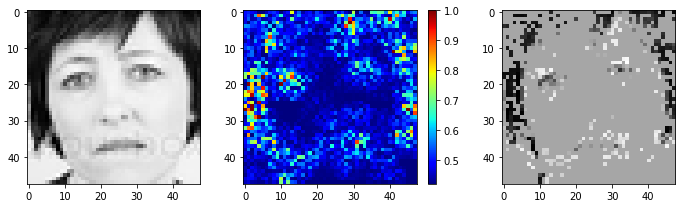

In [16]:
# 顯示圖片
# show original
fig=plt.figure(figsize=(10,3))
ax=fig.add_subplot(1,3,1)
axx=ax.imshow((test_x[_id]*255).reshape(48,48),cmap='gray')

# show heat map
ax=fig.add_subplot(1,3,2)
axx=ax.imshow(arrayHeatMap,cmap=plt.cm.jet)
plt.colorbar(axx) ## 顯示圖片右邊的bar
plt.tight_layout()

# show saliency map
floatThreashold=0.55
array_see=(test_x[_id]*255).reshape(48,48)
array_see[np.where(arrayHeatMap<=floatThreashold)]=np.mean(array_see)

ax=fig.add_subplot(1,3,3)
axx=ax.imshow(array_see,cmap='gray')
# plt.colorbar(axx) ## 顯示圖片右邊的bar
plt.tight_layout()

# filter

In [17]:
from pprint import pprint

In [18]:
intRecordFreq=20
intNumStep=160
intIterStep=160

In [19]:
dict_layer=dict([layer.name,layer] for layer in model.layers)
pprint(dict_layer)

{'conv2d_1': <keras.layers.convolutional.Conv2D object at 0x7ff273e4d8d0>,
 'conv2d_2': <keras.layers.convolutional.Conv2D object at 0x7ff273e4da90>,
 'dense_1': <keras.layers.core.Dense object at 0x7ff273e4dd68>,
 'dense_2': <keras.layers.core.Dense object at 0x7ff273e4df28>,
 'dropout_1': <keras.layers.core.Dropout object at 0x7ff273e4ddd8>,
 'flatten_1': <keras.layers.core.Flatten object at 0x7ff273e4dcc0>,
 'max_pooling2d_1': <keras.layers.pooling.MaxPooling2D object at 0x7ff273e4d908>,
 'max_pooling2d_2': <keras.layers.pooling.MaxPooling2D object at 0x7ff273e4db38>}


In [20]:
listFiltertImages=[]
arrInputImages=[]
intFilter=32
intIterationSteps=64 # 進行gradient的次數
intRecordFrequent=16

In [21]:
inputImage=model.input
list_layer_name=[layer for layer in dict_layer.keys() if "conv2d" in layer]
list_collect_layers=[dict_layer[name].output for name in list_layer_name]

In [22]:
print(list_collect_layers)

[<tf.Tensor 'conv2d_1/Relu:0' shape=(?, 48, 48, 32) dtype=float32>, <tf.Tensor 'conv2d_2/Relu:0' shape=(?, 24, 24, 32) dtype=float32>]


In [23]:
def makeNormalize(x):
    # utility function to normalize a tensor by its L2 norm
    return x / (kb.sqrt(kb.mean(kb.square(x))) + 1e-7)

In [49]:
def trainGradAscent(intIterationSteps, arrayInputImageData, targetFunction, intRecordFrequent):
    """
    Implement gradient ascent in targetFunction
    """
    listFilterImages = []
    floatLearningRate = 1e-2
    for i in range(intIterationSteps): 
        floatLossValue, arrayGradientsValue = targetFunction([arrayInputImageData, 0])
        arrayInputImageData += arrayGradientsValue * floatLearningRate #更新圖片 Q: 為什麼使用+??
        if i % intRecordFrequent == 0:
            listFilterImages.append((arrayInputImageData, floatLossValue))
#             print("#{}, loss rate: {}".format(i, floatLossValue))
    return listFilterImages

# util function to convert a tensor into a valid image
def deprocessImage(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5 # Q: 為什麼要+0.5?
    x = np.clip(x, 0, 1)

    # convert to array
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    # print(x.shape)
    return x


In the #0
In the #1
In the #2
In the #3
In the #0
In the #1
In the #2
In the #3


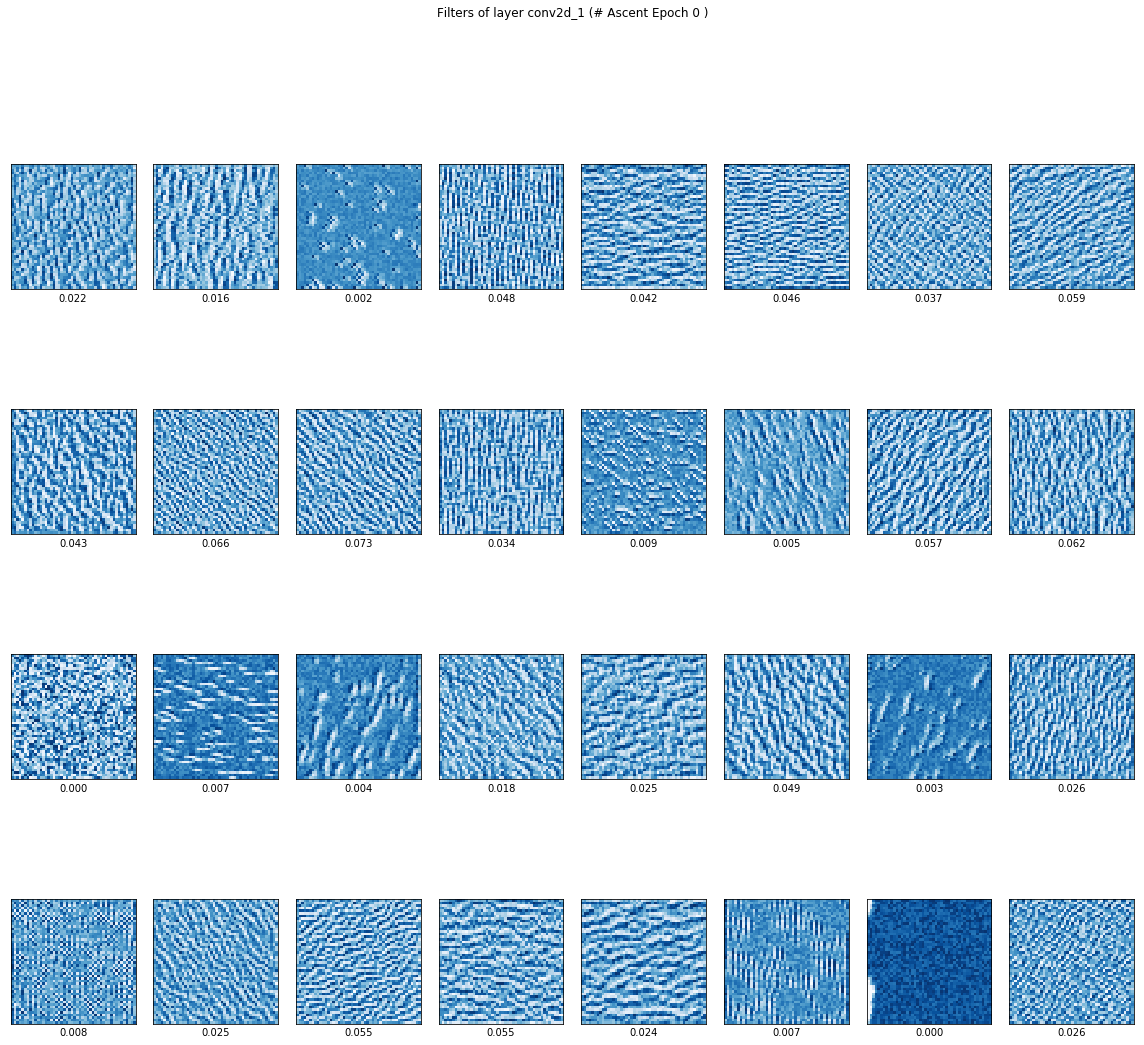

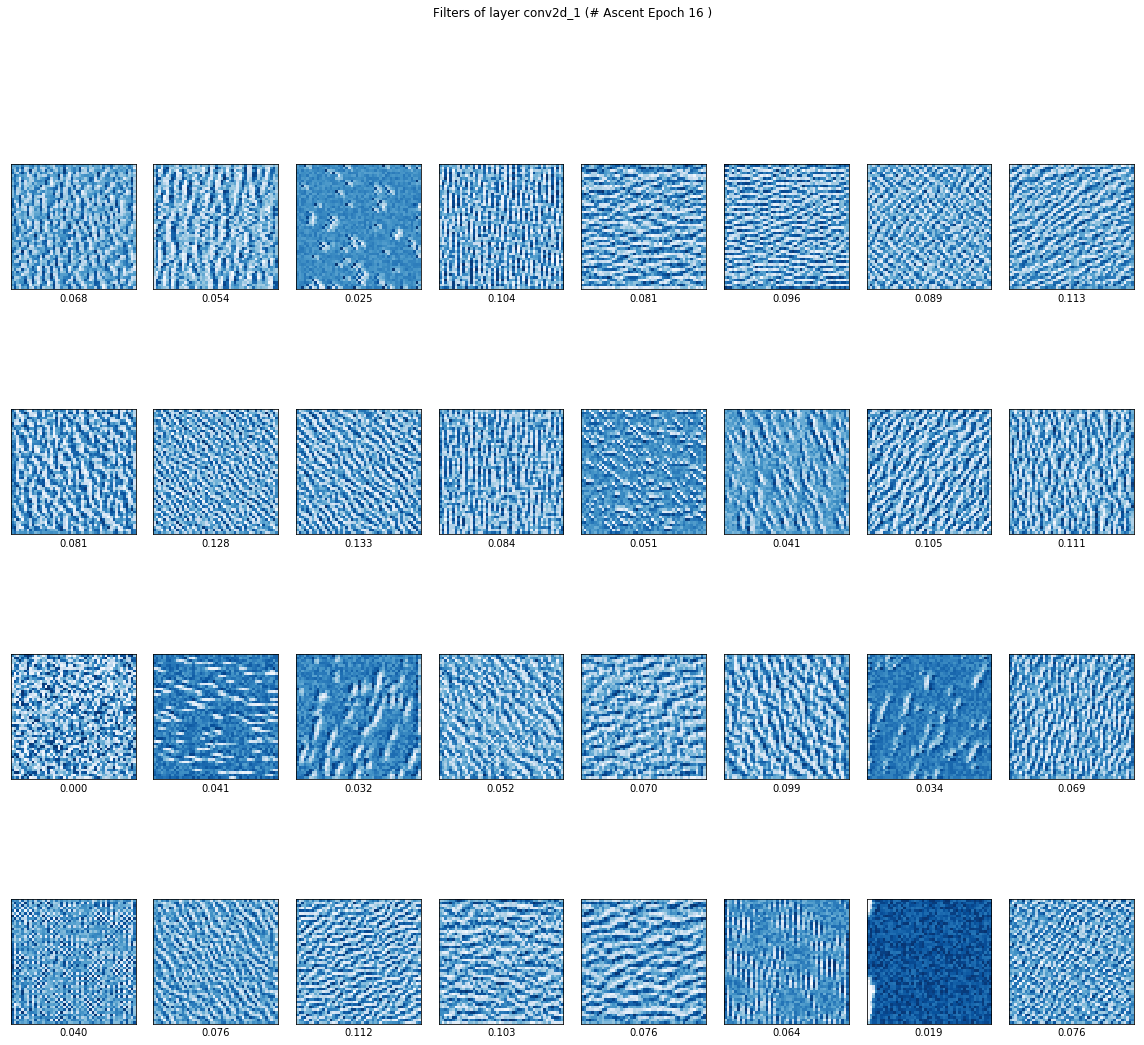

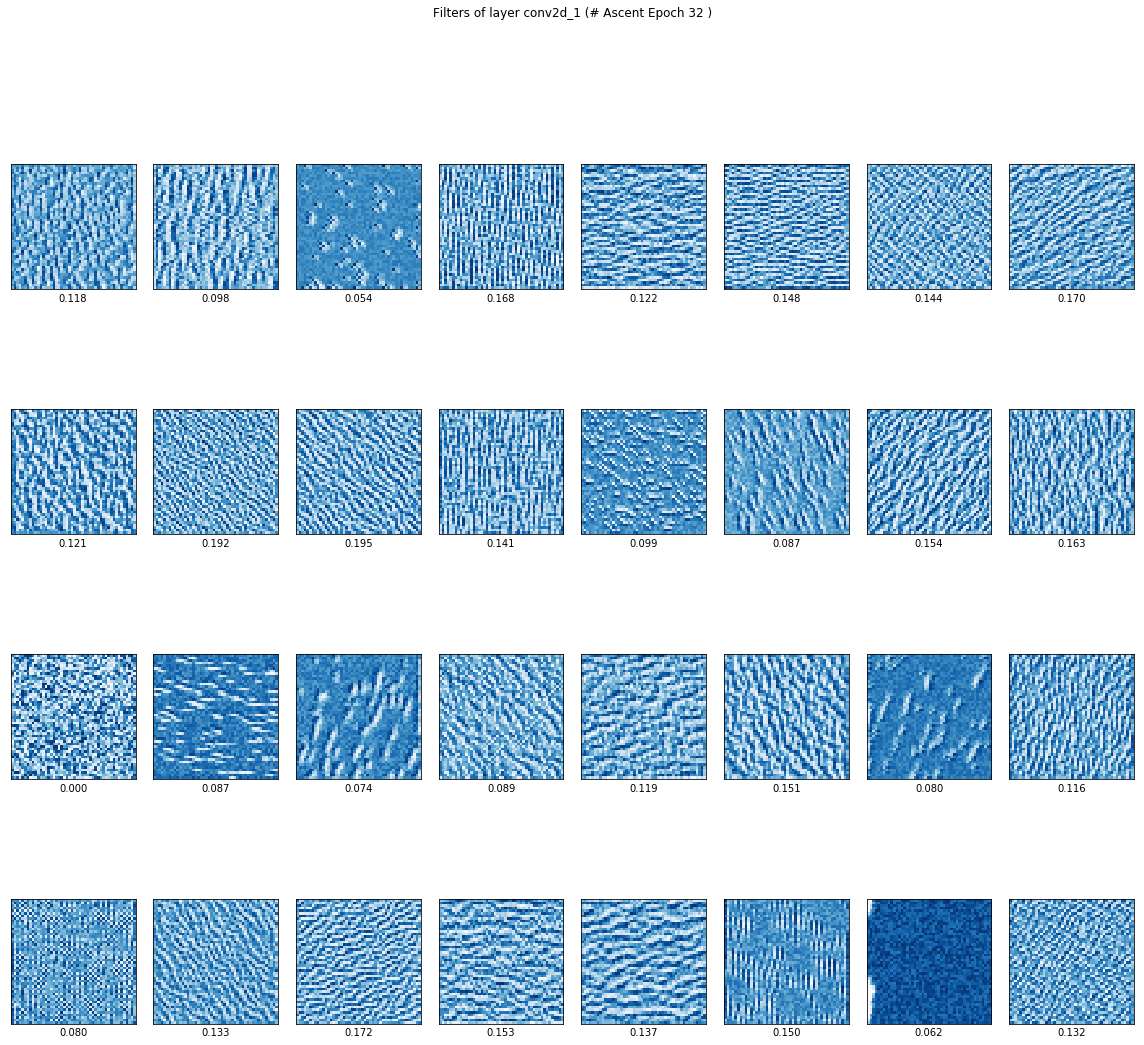

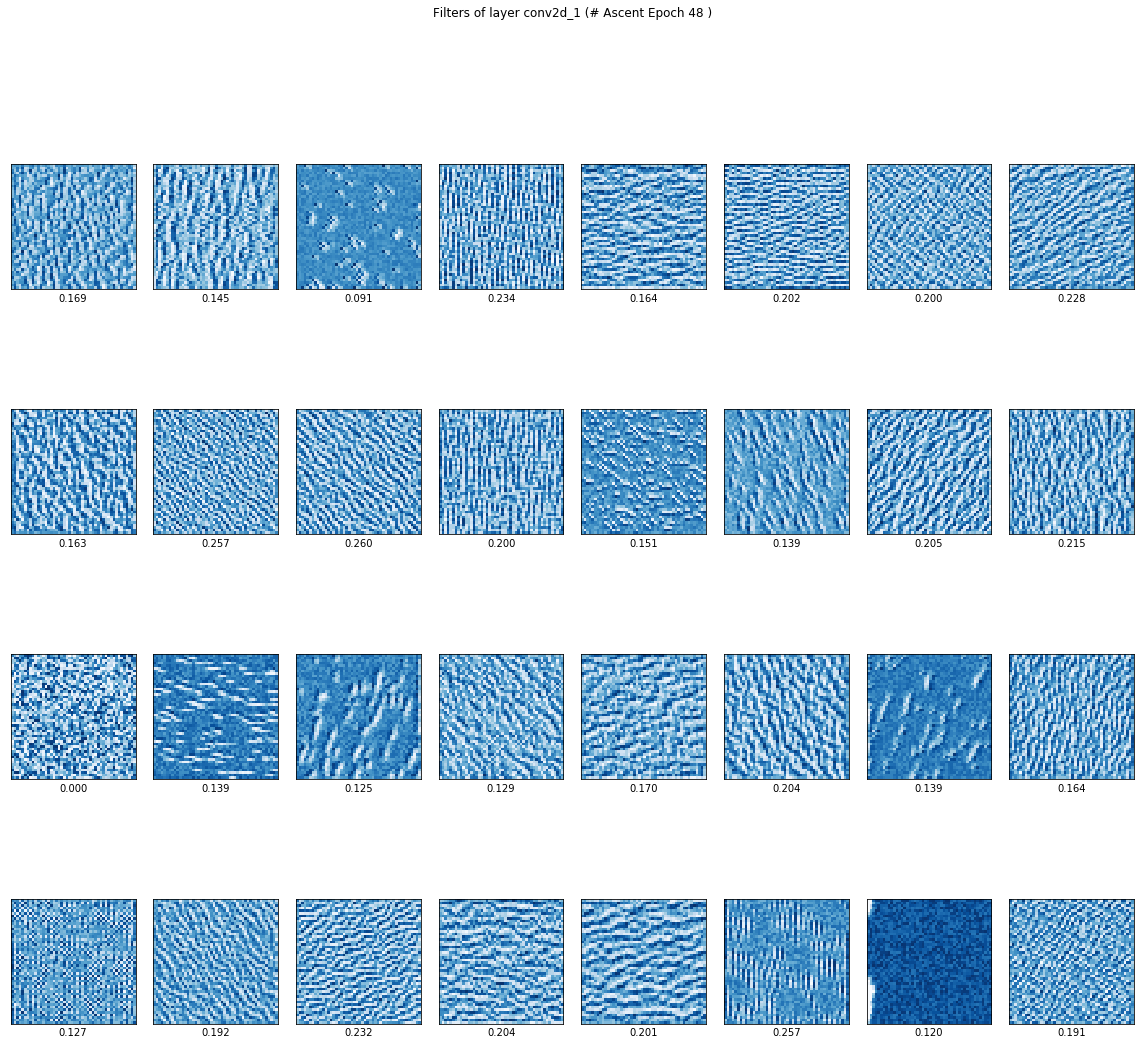

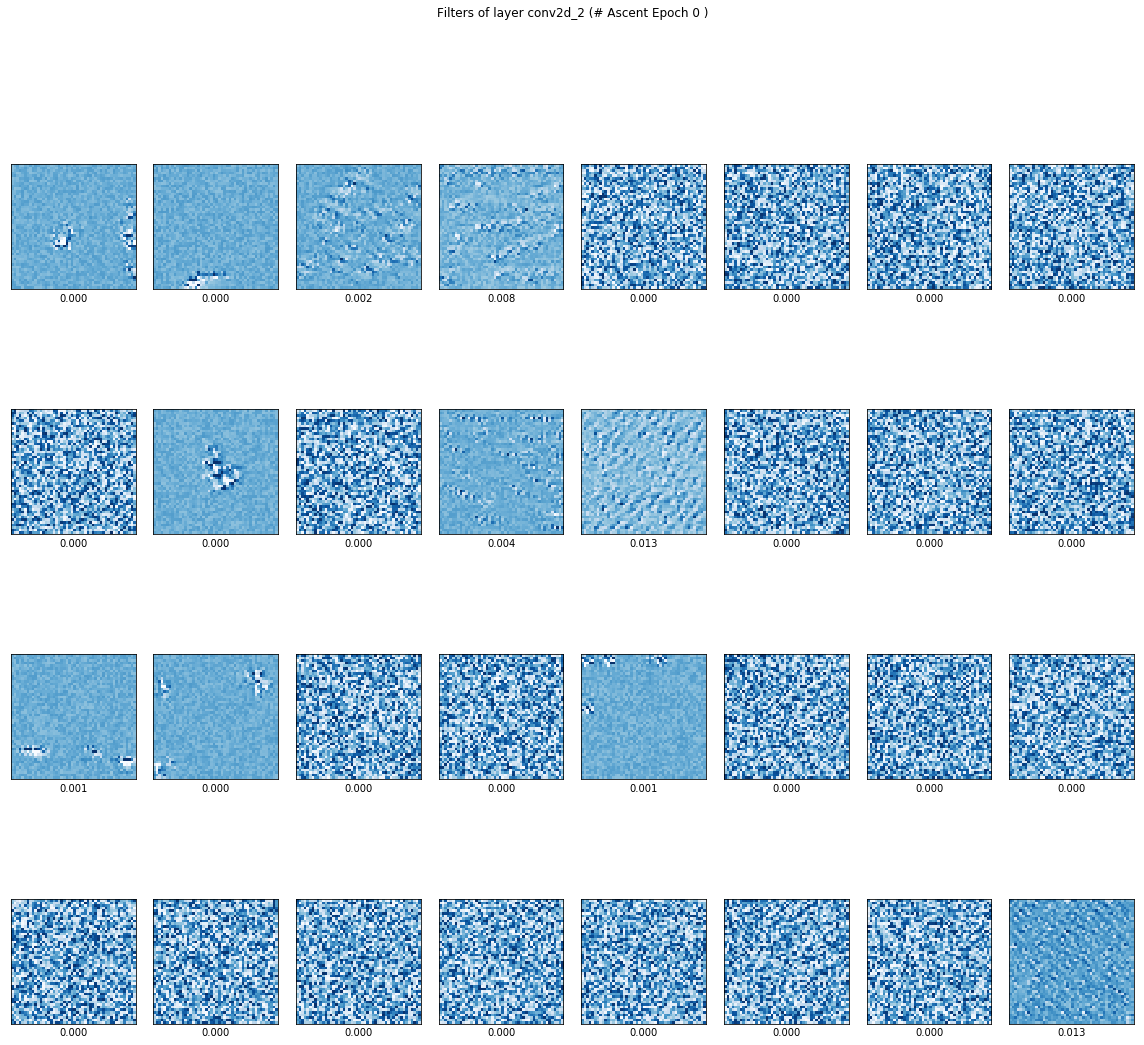

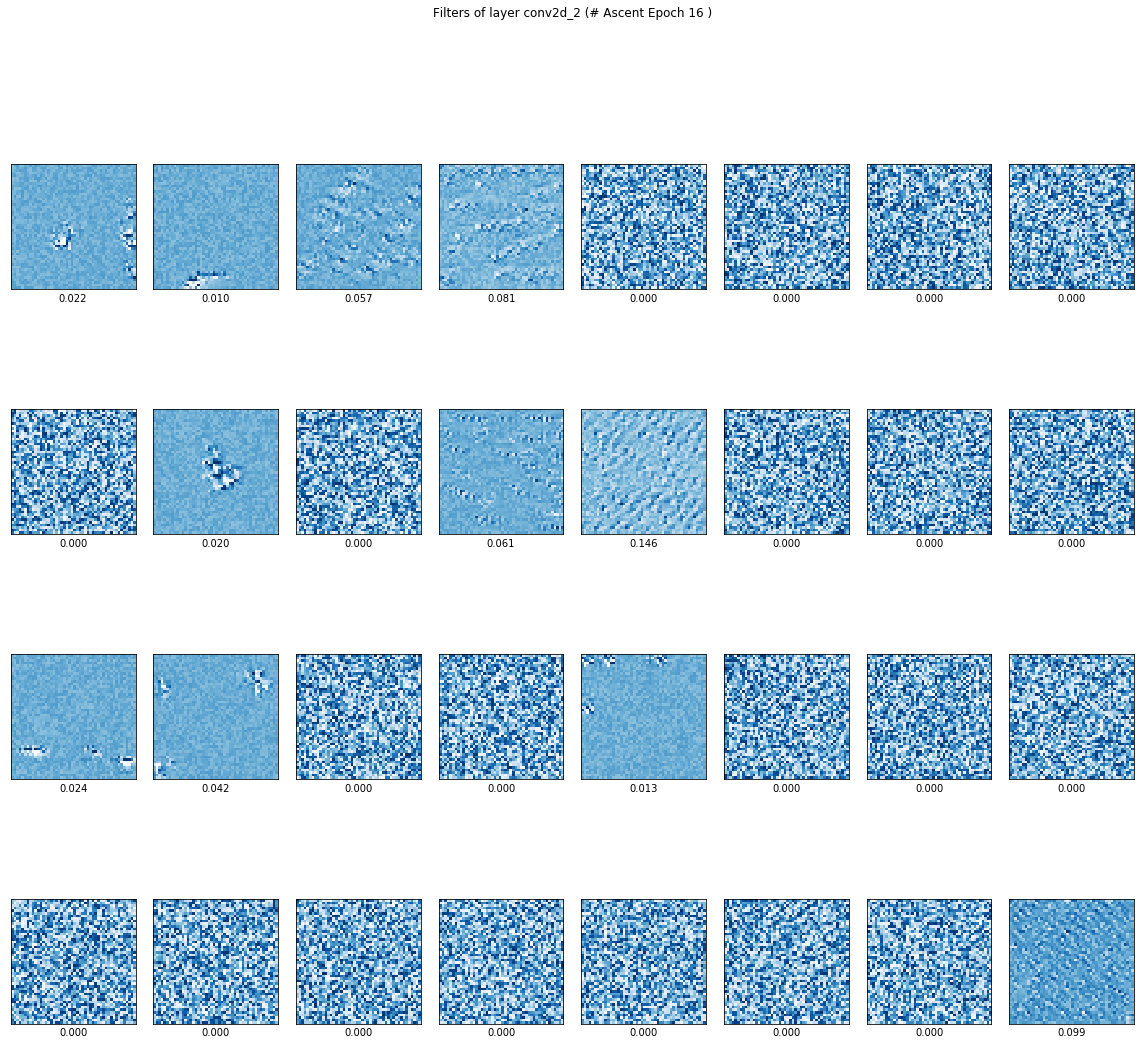

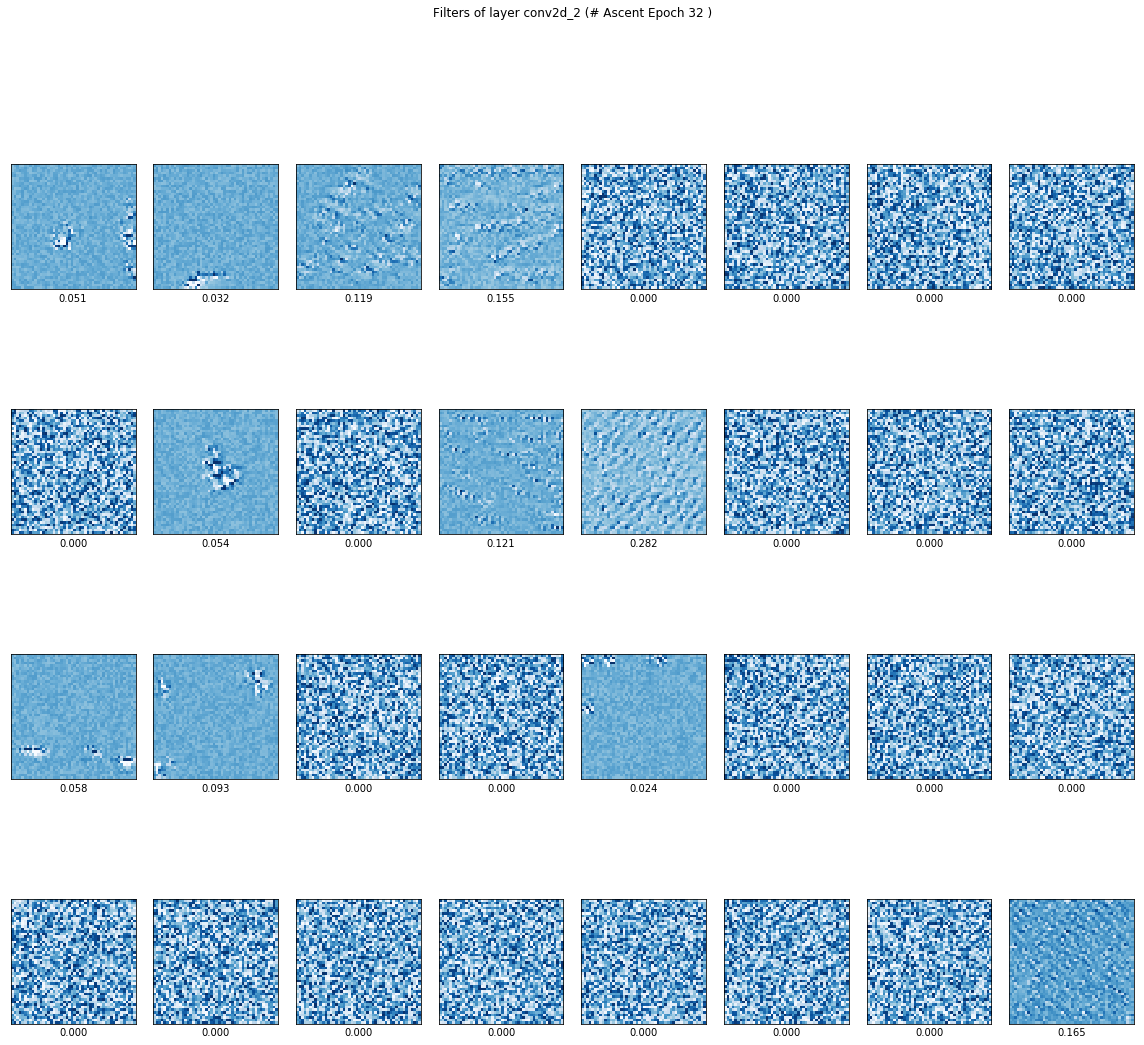

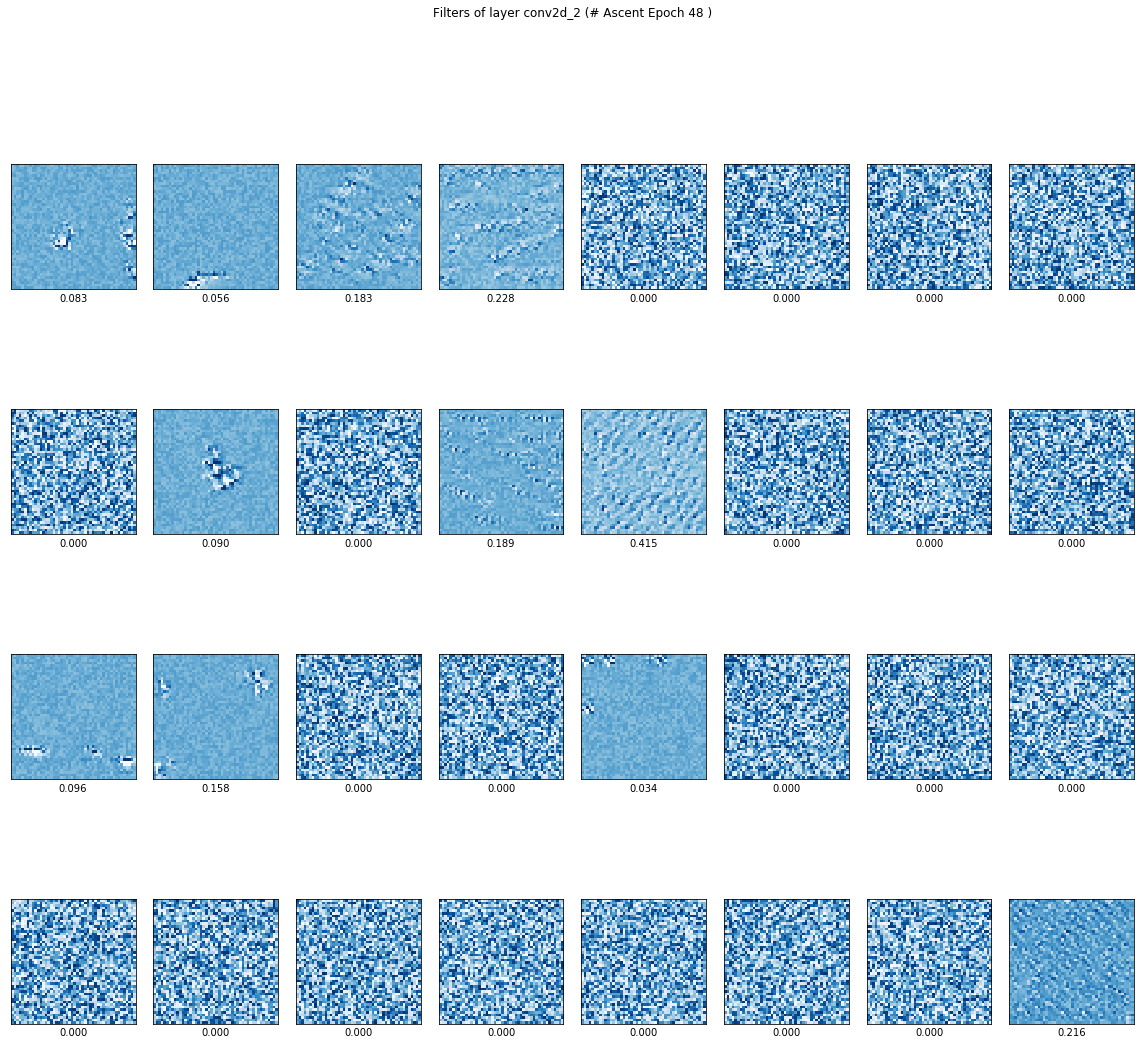

In [53]:
for cnt, fn in enumerate(list_collect_layers):
        listFilterImages = []
        intFilters = 32
        for i in range(intFilters):
            arrayInputImage = np.random.random((1, 48, 48, 1)) # random noise
            tensorTarget = kb.mean(fn[:, :, :, i]) # 對所有顏色進行平均(計算loss)
#             print(tensorTarget)  # Tensor("Mean_410:0", shape=(), dtype=float32)
            # 對計算出來的結果作normalization
            tensorGradients = makeNormalize(kb.gradients(tensorTarget, inputImage)[0])
            targetFunction = kb.function([inputImage, kb.learning_phase()], [tensorTarget, tensorGradients])

            # activate filters
            listFilterImages.append(trainGradAscent(intIterationSteps, arrayInputImage, targetFunction, intRecordFrequent))
        
        for it in range(intIterationSteps//intRecordFrequent):
            print("In the #{}".format(it))
            fig = plt.figure(figsize=(16, 17))
            for i in range(intFilters):
                ax = fig.add_subplot(intFilters/8, 8, i+1)
                arrayRawImage = listFilterImages[i][it][0].squeeze()
                ax.imshow(deprocessImage(arrayRawImage), cmap="Blues")
                plt.xticks(np.array([]))
                plt.yticks(np.array([]))
                plt.xlabel("{:.3f}".format(listFilterImages[i][it][1])) # 顯示loss function
                plt.tight_layout()
            fig.suptitle("Filters of layer {} (# Ascent Epoch {} )".format(list_layer_name[cnt], it*intRecordFrequent))

# 畫出經過filter(conv)的result

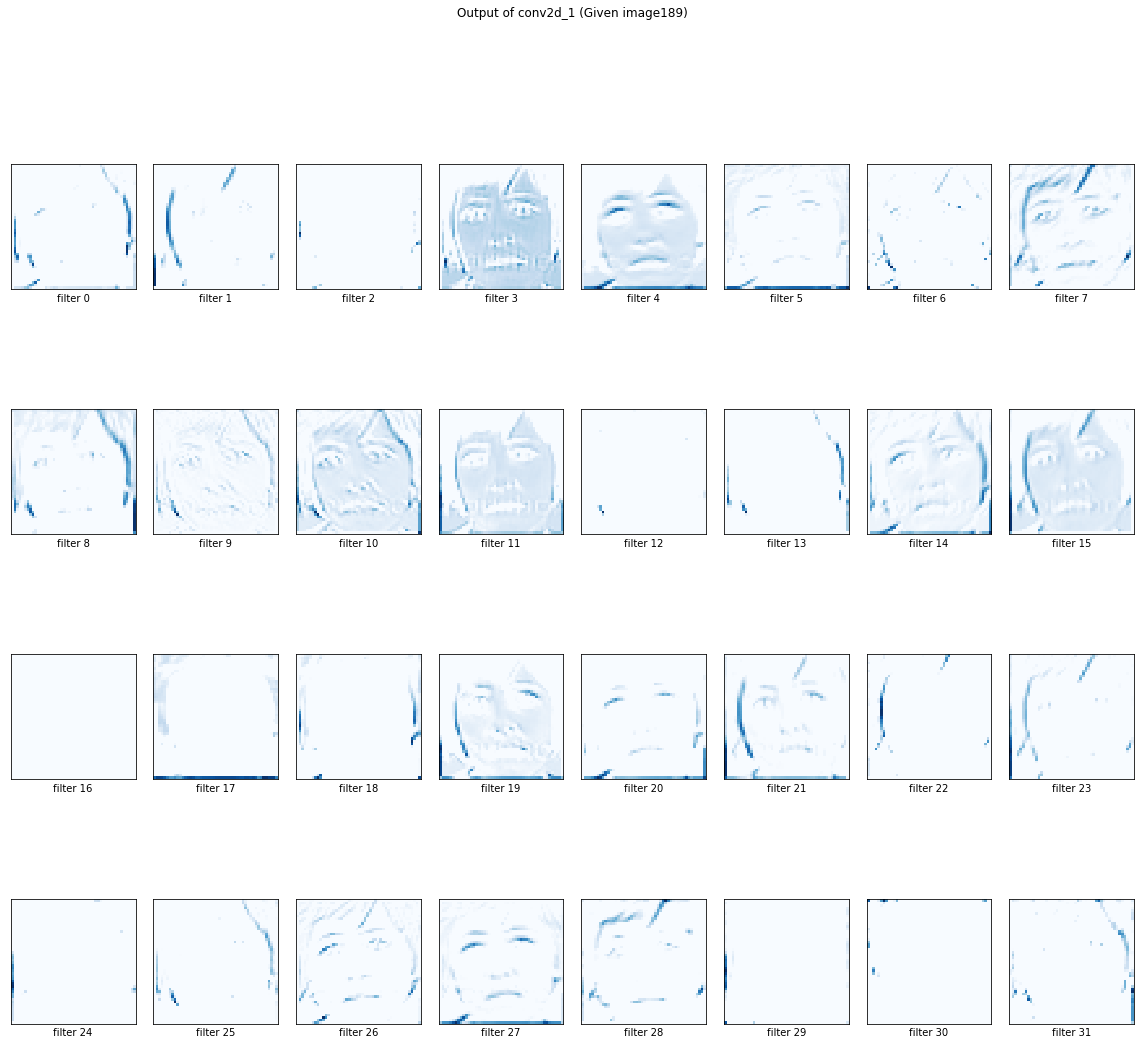

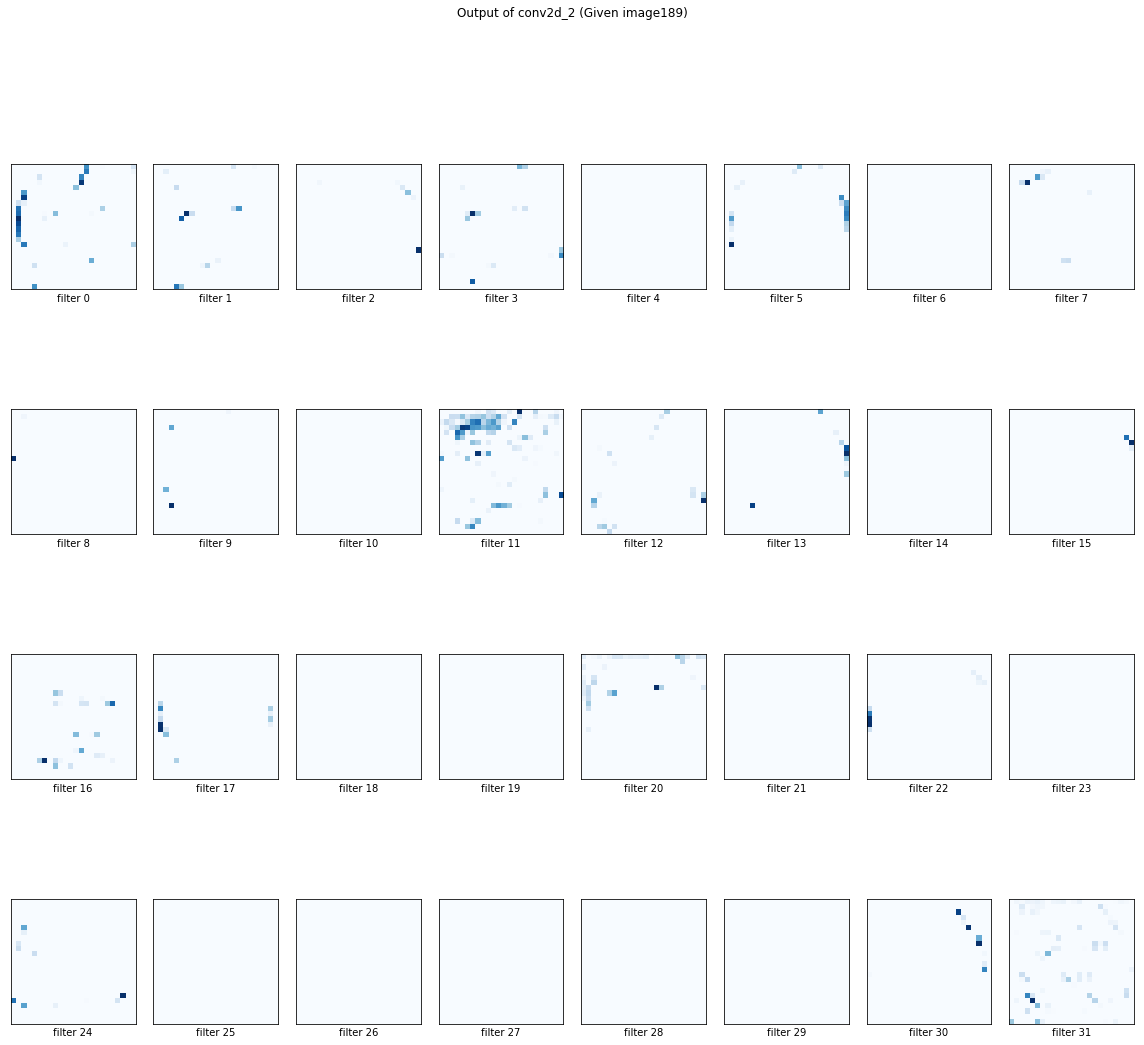

In [26]:
intImageHeight = 48
intImageWidth = 48
dictLayer = dict([layer.name, layer] for layer in model.layers)
listCollectLayers = [kb.function([inputImage, kb.learning_phase()], [dictLayer[name].output]) for name in list_layer_name]


for cnt, fn in enumerate(listCollectLayers):
    arrayPhoto = test_x[_id].reshape(1, intImageWidth, intImageHeight, 1)
    listLayerImage = fn([arrayPhoto,0])#get the output of that layer list (1, 1, 48, 48, 64)
    
    fig = plt.figure(figsize=(16, 17))
    intFilters = 32
    for i in range(intFilters):
        ax = fig.add_subplot(intFilters/8, 8, i+1)
        ax.imshow(listLayerImage[0][0, :, :, i], cmap="Blues")
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))
        plt.xlabel("filter {}".format(i))
        plt.tight_layout()
    fig.suptitle("Output of {} (Given image{})".format(list_layer_name[cnt], _id))

# 畫出經過filter(conv)的result

In [27]:
from keras.models import Model
conv1_layer_model = Model(inputs=model.input,
                                     outputs=model.layers[0].output)

In [28]:
conv1_output = conv1_layer_model.predict(test_x[_id].reshape(-1,48,48,1))
conv1_output.shape

(1, 48, 48, 32)

In [29]:
print(conv1_output[0,:,:,0].shape)
print(conv1_layer_model.summary())

(48, 48)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1_input (InputLay (None, 48, 48, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 32)        320       
Total params: 320
Trainable params: 320
Non-trainable params: 0
_________________________________________________________________
None


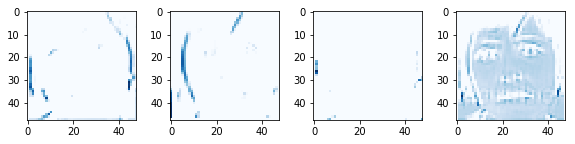

In [30]:
fig=plt.figure(figsize=(16,17)) # figsize表示圖片的大小
for i in range(4):
    ax=fig.add_subplot(1,8,i+1) # x軸，y軸，第幾張圖片
    ax.imshow(conv1_output[0,:,:,i],cmap='Blues') # conv1_output表示經過conv1的結果，0表示第0個sample,i表示第幾個filter
plt.tight_layout()

# 畫出filter  感覺是錯的

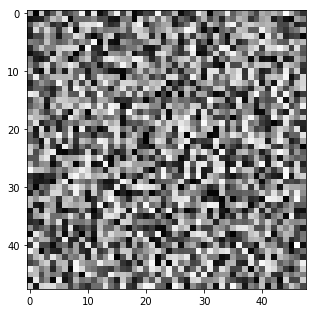

In [48]:
intFilter=32

noise=np.random.random((1,48,48,1))
input_layer=model.input
m_fn=list_collect_layers[0]
# print(m_fn)
# 使用第0張filter
m_target=kb.mean(fn[:,:,:,0]) #　這裡沒有run下面的enumerate會出錯 why??
m_grad=kb.gradients(m_target,input_layer)
m_grad=makeNormalize(m_grad[0])
m_fun=kb.function([input_layer],[m_target,m_grad])
for i in range(16):
    noise=np.random.random((1,48,48,1))
    floatLoss,Grad=m_fun([noise])
    noise+=Grad*1e-2

fig=plt.figure(figsize=(17,16))
ax=fig.add_subplot(1,3,1)
ax.imshow(deprocessImage(noise.reshape(48,48)),'gray')

In [33]:
m_fn=list_collect_layers[0]
print(m_fn)

Tensor("conv2d_1/Relu:0", shape=(?, 48, 48, 32), dtype=float32)


In [34]:
for cnt,fn in enumerate(list_collect_layers):
    print(m_fn)

Tensor("conv2d_1/Relu:0", shape=(?, 48, 48, 32), dtype=float32)
Tensor("conv2d_1/Relu:0", shape=(?, 48, 48, 32), dtype=float32)
